In [51]:
from awips.dataaccess import DataAccessLayer
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.constants import convert_temperature

import xarray as xr

from pyproj import CRS
import numpy as np
from pyproj import Transformer, transform
import pyproj

import cartopy.feature as cfeature

In [2]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu") #access URL
request = DataAccessLayer.newDataRequest() # make request from created URL
request.setDatatype("grid") #filter to grid data
request.setLocationNames("RAP13") #filter to specific location
request.setParameters("T") #filter to parameter/variable
request.setLevels("2.0FHAG") #filter to level

In [3]:
cycles = DataAccessLayer.getAvailableTimes(request, True) #(request = request from above, what data/etc. we want, True = only unique times returned, no forecast hour
times = DataAccessLayer.getAvailableTimes(request) #now gets forecast hours for request above
fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times) 

# Get the most recent grid data
response = DataAccessLayer.getGridData(request, [fcstRun[0]])

In [52]:
response; #output - [<awips.dataaccess.PyGridData.PyGridData at 0x1086612d0>]
request; #output - <dynamicserialize.dstypes.com.raytheon.uf.common.dataaccess.impl.DefaultDataRequest.DefaultDataRequest at 0x108cdf250>
grid = response[0] #output - <awips.dataaccess.PyGridData.PyGridData at 0x1086612d0>
grid.getUnit() #output = 'K'
data = grid.getRawData() #output = array with len 337
lons, lats = grid.getLatLonCoords() #output = array with len 337 for both
        #first element is a numpy array of lons
        #second element is a numpy array of lats
        

# Convert temp from Kelvin to F
destUnit = 'F'
data = convert_temperature(data, 'K', destUnit)

In [38]:
x_da = xr.DataArray(x_coords)
y_da = xr.DataArray(y_coords)
temp_da = xr.DataArray(data)

#data is dataset from original EDEX request/response

In [39]:
x_da.name = 'x_data'
y_da.name = 'y_data'
temp_da.name = 'temperature'

merged_data = xr.merge([x_da, y_da, temp_da]).rename_dims({'dim_0':'longitude', 'dim_1': 'latitude'})
merged_data

<xarray.Dataset>
Dimensions:      (longitude: 337, latitude: 451)
Dimensions without coordinates: longitude, latitude
Data variables:
    x_data       (longitude, latitude) float64 -2.434e+06 ... 3.369e+06
    y_data       (longitude, latitude) float64 1.838e+06 ... -2.117e+06
    temperature  (longitude, latitude) float32 55.94 56.05 56.16 ... 83.28 83.16

[CF Mapping Attributes](https://github.com/cf-convention/cf-conventions/wiki/Mapping-from-CF-Grid-Mapping-Attributes-to-CRS-WKT-Elements#table-4---specific-projection-parameter-names)

In [37]:
awips_crs = CRS.from_proj4("+proj=lcc +lat_0=25 +lon_0=-95 +lat_1=25 +x_0=0 +y_0=0 +k_0=1 +datum=WGS84 +units=m +no_defs")
awips_crs

<Projected CRS: +proj=lcc +lat_0=25 +lon_0=-95 +lat_1=25 +x_0=0 +y ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (1SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

***

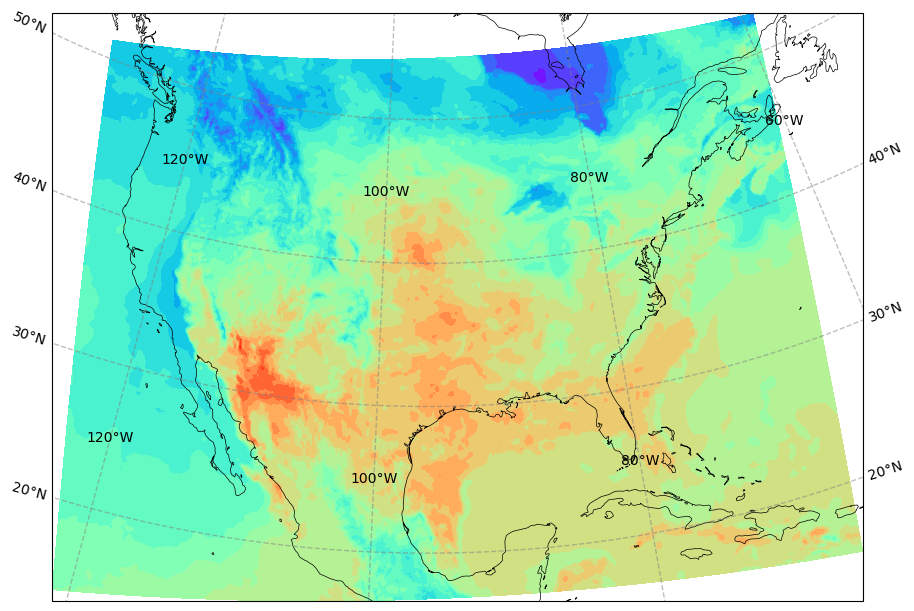

In [49]:
#define coordinate system and projection 
projection = ccrs.LambertConformal()
crs = ccrs.PlateCarree()
transform = ccrs.LambertConformal()

#create figure and axes (subplots #, #, # is amount of dimensions in dataset)

fig, ax = plt.subplots(figsize=(9,6), subplot_kw=dict(projection=projection), layout='constrained')

# set extent - full globe (0, 357, -55, 55)
# lon_min = 0
# lon_max = 357
# lat_min = -55
# lat_max = 55

pl_1 = ax.contourf(merged_data.x_data, merged_data.y_data, temp, transform=transform, levels=20, cmap=cmap)
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), lw=0.5)
# ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
gls = ax.gridlines(crs=crs, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gls.top_labels=True